In [1]:
# importing relevant libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn import metrics
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Lasso, Ridge
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import missingno as msno

In [2]:
# train and test data files are provided as separate csv files

train = pd.read_csv('./datasets/train.csv')
test = pd.read_csv('./datasets/test.csv')

In [3]:
# inspecting train file
train.head(3)

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000


In [4]:
# inspecting test file
test.head(3)

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,4,2006,WD
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,8,2006,WD
2,2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,9,2006,New


After inspecting train and test above, 'train' has one additional column ('Sale Price') than test.

Based on this analysis, I will use the 'train' dataset to build and train my model and then use the 'test' dataset to evaluate the model.

Because I will train the model on one data set and apply the model to another, it is critical that any data cleaning steps be applied to both data sets. 

### Modifying the columns names
This is purely personal preference--I find it easier to analyze if the column names and perform subsequent modeling if words are:
 - lowercased
 - spaces represented by an underscore
 
 Because there are 81 columns in the dataset, I wanted to find an efficient way to achieve this, so I built a dictionary comprehension.
 
This dictionary comprehension can be used in other projects by substituting another dataframe name in place of 'train' and substituting the characters you want to manipulate in the "replace statement"

In [11]:
train.columns = [i.replace(' ', '_').lower() for i in train.columns] 
test.columns = [i.replace(' ', '_').lower() for i in test.columns]

In [12]:
# confirming the dictionary comprehension performed as expected
# reveals the format I desired
train.columns

Index(['id', 'pid', 'ms_subclass', 'ms_zoning', 'lot_frontage', 'lot_area',
       'street', 'alley', 'lot_shape', 'land_contour', 'utilities',
       'lot_config', 'land_slope', 'neighborhood', 'condition_1',
       'condition_2', 'bldg_type', 'house_style', 'overall_qual',
       'overall_cond', 'year_built', 'year_remod/add', 'roof_style',
       'roof_matl', 'exterior_1st', 'exterior_2nd', 'mas_vnr_type',
       'mas_vnr_area', 'exter_qual', 'exter_cond', 'foundation', 'bsmt_qual',
       'bsmt_cond', 'bsmt_exposure', 'bsmtfin_type_1', 'bsmtfin_sf_1',
       'bsmtfin_type_2', 'bsmtfin_sf_2', 'bsmt_unf_sf', 'total_bsmt_sf',
       'heating', 'heating_qc', 'central_air', 'electrical', '1st_flr_sf',
       '2nd_flr_sf', 'low_qual_fin_sf', 'gr_liv_area', 'bsmt_full_bath',
       'bsmt_half_bath', 'full_bath', 'half_bath', 'bedroom_abvgr',
       'kitchen_abvgr', 'kitchen_qual', 'totrms_abvgrd', 'functional',
       'fireplaces', 'fireplace_qu', 'garage_type', 'garage_yr_blt',
       'g

## Exploratory Data Analysis (EDA)

This is a critical component of any data science project. Performing effective EDA can reveal insights about the data that can be used to build a model as well as help the data scientist identify necessary data cleaning steps before building their model.

First I want to efficiently evaluate my data sets to inspect data types, identify null values in the data set, and explore the summary statistics for each column available. To achieve this, I will define a function, that takes my data as an input, and returns a data frame where each feature in my data set is now a row and the summary statistics are columns. 

In [13]:

def ames_eda(df): 
    eda_df = {}
    eda_df['null_sum'] = df.isnull().sum()
    eda_df['null_pct'] = df.isnull().mean()
    eda_df['dtypes'] = df.dtypes
    eda_df['count'] = df.count()
    eda_df['mean'] = df.mean()
    eda_df['median'] = df.median()
    eda_df['min'] = df.min()
    eda_df['max'] = df.max()
    
    return pd.DataFrame(eda_df)

ames_eda(train)

,null_sum,null_pct,dtypes,count,mean,median,min,max
1st_flr_sf,0,0.000000,int64,2051,1164.488055,1093.0,334,5095
2nd_flr_sf,0,0.000000,int64,2051,329.329108,0.0,0,1862
3ssn_porch,0,0.000000,int64,2051,2.591419,0.0,0,508
alley,1911,0.931741,object,140,NaN,NaN,NaN,NaN
bedroom_abvgr,0,0.000000,int64,2051,2.843491,3.0,0,8
...,...,...,...,...,...,...,...,...
utilities,0,0.000000,object,2051,NaN,NaN,AllPub,NoSewr
wood_deck_sf,0,0.000000,int64,2051,93.833740,0.0,0,1424
year_built,0,0.000000,int64,2051,1971.708922,1974.0,1872,2010
year_remod/add,0,0.000000,int64,2051,1984.190151,1993.0,1950,2010


From the EDA dataframe above, I can see that there are object and integer columns. I want to inspect what other column types there are.

In [14]:
train.dtypes.value_counts()

object     42
int64      28
float64    11
dtype: int64

In [15]:
# returns list of my object columns
train.select_dtypes(include=['object']).columns

Index(['ms_zoning', 'street', 'alley', 'lot_shape', 'land_contour',
       'utilities', 'lot_config', 'land_slope', 'neighborhood', 'condition_1',
       'condition_2', 'bldg_type', 'house_style', 'roof_style', 'roof_matl',
       'exterior_1st', 'exterior_2nd', 'mas_vnr_type', 'exter_qual',
       'exter_cond', 'foundation', 'bsmt_qual', 'bsmt_cond', 'bsmt_exposure',
       'bsmtfin_type_1', 'bsmtfin_type_2', 'heating', 'heating_qc',
       'central_air', 'electrical', 'kitchen_qual', 'functional',
       'fireplace_qu', 'garage_type', 'garage_finish', 'garage_qual',
       'garage_cond', 'paved_drive', 'pool_qc', 'fence', 'misc_feature',
       'sale_type'],
      dtype='object')

By inspecting the data dictionary provided, I can see that many of these string/object columns, such as 'central_air' and 'heating_qc'are categorical variables that:
1. can be converted to numeric values
2. are intuitively related to the price of a house--a house with central air would intuitively have a higher sale price than one without, holding all else constant. 

### Exploring relationships with our target
Another part of EDA is to explore whether there is a relationship between our potential feature columns and our target, the home's sale price.

Given the different data types of our features, we need to take a different approach to visually exploring the relationships.

For example, for our numeric columns, we can calculate the correlations between potential features and our target and even create a nice visual out of it, but correlations won't be calculated for non-numeric columns. This will be addressed further below.

Below, I've calculated the pairwise correlation between all of the numeric variables in the data frame and our target, sale price. 

Pandas' corrwith method will return a pair-wise correlation for each numeric variable with the target and ignore non-numeric columns. 

Using seaborn, we can visualize these pair-wise correlations. For ease of analysis, the code below sorts the pair-wise correlations by absolute value.

Unsurprisingly, features such as the overall quality of the home and the size of the living area have a strong relationship with the sale price

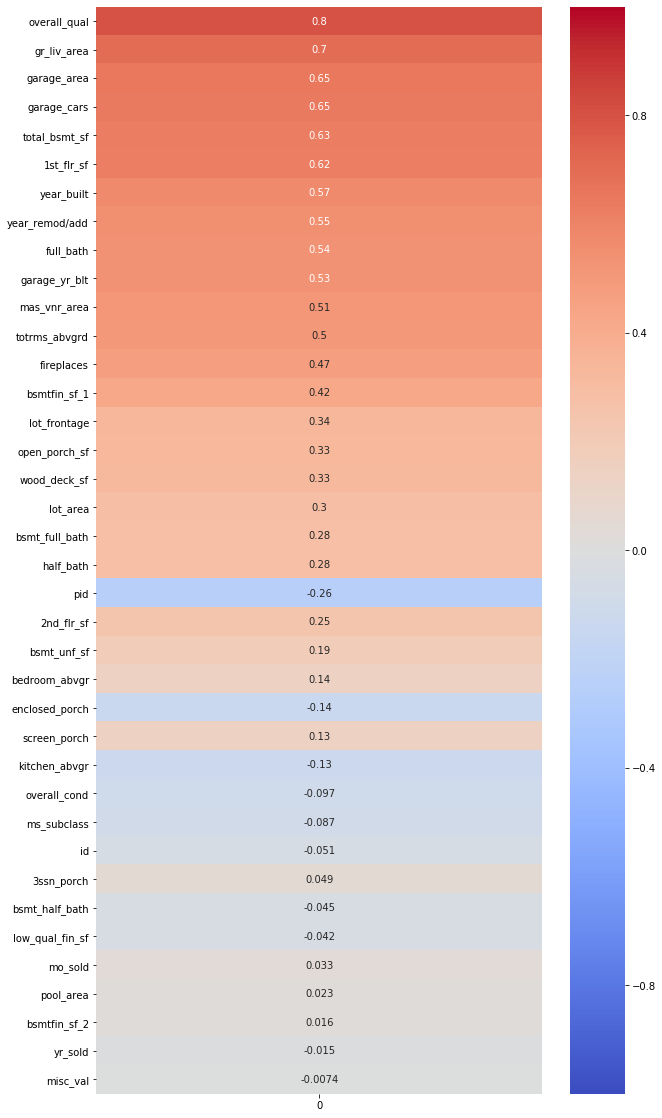

In [17]:
correlations = train.corrwith(train['saleprice']).iloc[:-1].to_frame()
correlations['abs'] = correlations[0].abs()
sorted_correlations = correlations.sort_values('abs', ascending=False)[0]

fig, ax = plt.subplots(figsize=(10,20))
sns.heatmap(sorted_correlations.to_frame(), \
            cmap='coolwarm', annot=True, vmin=-1, vmax=1, ax=ax);

But what about non-numeric columns. We cannot just ignore 

For these object columns that contain ordinal or categorical values, it is important that we evaluate whether there is a categorical relationship to sale price, our target variable.

But what about our non-numeric columns? Ordinal and categorical variables such as 'exterior condition' and 'central air' intuitively would have a relationship to sale price. It is critical that we visualize this!

A great way to achieve this is to generate a boxplot that compares the values of a ordinal/categorical and visualize a relationship with sale price. 

Again, seaborn's visualization library provides great tools to visualize the relationship of interest. As we can see from the boxplots below, there is a clear relationship between non-numeric values such as excellent kitchen quality with sale price. Based on this, we will need to convert these columns to represent numeric values when we clean our data before modeling. 

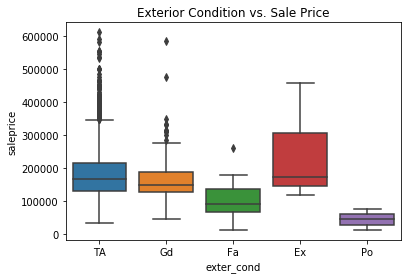

In [18]:
sns.boxplot(train['exter_cond'], 
            train['saleprice']).set_title('Exterior Condition vs. Sale Price');

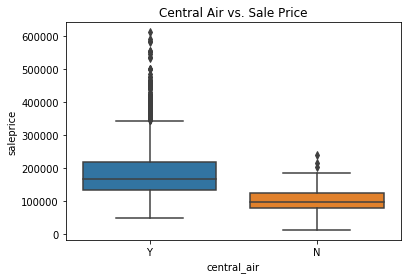

In [19]:
sns.boxplot(train['central_air'], 
            train['saleprice']).set_title('Central Air vs. Sale Price');

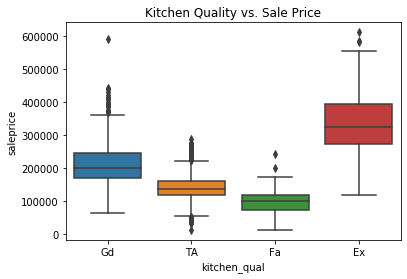

In [20]:
sns.boxplot(train['kitchen_qual'], 
            train['saleprice']).set_title('Kitchen Quality vs. Sale Price');

For these string variables that take on ordinal values or we can easily convert them to a numeric rank.

For example, the central air variable can be changed to '1' for 'yes' and '0' for 'no.' 
Similarly, we can do the same with a quality scale. The 'exterior condition' column takes on 5 values with a scale ranging from "poor" to "excellent". These can be converted by assigning each category a numeric value. For example:
 - Excellent = 5
 - Good = 4
 - TA (typical/average in the data dictionary) = 3
 - Fair = 2
 - Poor = 1 
We can even reserve zero for observations that are missing. 

But what about variables without a clear, ordered relationship? 

For example, the 'neighborhood' column contains string values detailing what neighborhood the home is located in. Without knowing the intimate details of the Ames, Iowa real estate market, it is difficult to assign numeric values to the variable. We can't simply assign random numbers or number them alphabetically as python will read neighborhood B as being more highly correlated with sale price than neighborhood A, but less than neighborhood C--but this may not be the actual case! So what do we do? 

As we can see, from the box plots below, some neighborhoods clearly have higher sale prices have higher sale prices,than others possibly due to being located in a desirable neighborhood or convenient location. 

Even string variables that do not have take on ordinal values can be easily converted to a numerical amount by dummifying. Pandas provides a method to get dummify the variables--for each value (in this case neighborhood) a new feature will be created and the row will have a value of 0 or 1 for that column--a 1 signifying that in the original string column, a row contained the value that is now in the column name.

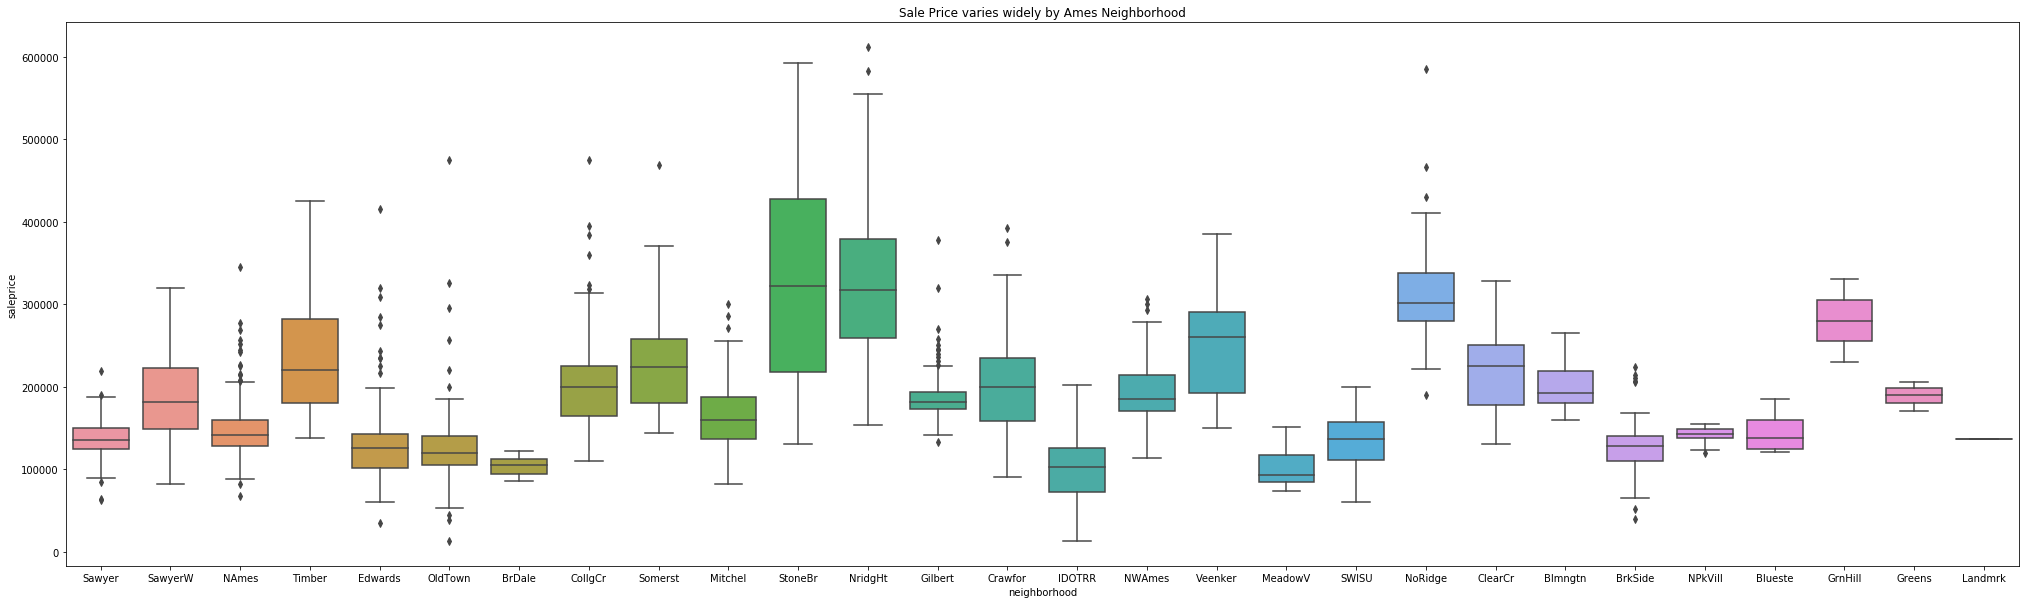

In [21]:
plt.figure(figsize=(35,10))
sns.boxplot(train['neighborhood'], 
            train['saleprice']).set_title('Sale Price varies widely by Ames Neighborhood');

We will use the pandas get dummies method to convert these to numeric values. It is important that we call the 'drop_first' argument and set it equal to 'True' This will dummify all variables after dropping the first one. We do this because it is important that a categorical variable of K categories, or levels, usually enters a regression as a sequence of K-1 dummy variables and the dropped variable will serve as our reference category. If a row has a value of 0 for all categories, we know that that observation belonged to the dropped column.

In [22]:
# dummifying neighborhood in the train dataset
pd.get_dummies(train, columns=['neighborhood'], drop_first=True)


,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,...,neighborhood_NoRidge,neighborhood_NridgHt,neighborhood_OldTown,neighborhood_SWISU,neighborhood_Sawyer,neighborhood_SawyerW,neighborhood_Somerst,neighborhood_StoneBr,neighborhood_Timber,neighborhood_Veenker
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,0,0,1,0,0,0,0,0
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,0,0,0,1,0,0,0,0
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,0,0,0,0,0,0,0,0
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,0,0,0,0,0,0,1,0
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,1587,921126030,20,RL,79.0,11449,Pave,NaN,IR1,HLS,...,0,0,0,0,0,0,0,0,1,0
2047,785,905377130,30,RL,NaN,12342,Pave,NaN,IR1,Lvl,...,0,0,0,0,0,0,0,0,0,0
2048,916,909253010,50,RL,57.0,7558,Pave,NaN,Reg,Bnk,...,0,0,0,0,0,0,0,0,0,0
2049,639,535179160,20,RL,80.0,10400,Pave,NaN,Reg,Lvl,...,0,0,0,0,0,0,0,0,0,0


In [109]:
# dummifying neighborhood in the train dataset#
train = pd.get_dummies(train, columns=['neighborhood'], drop_first=True)

# dummifying neighborhood in the test dataset
test = pd.get_dummies(test, columns=['neighborhood'], drop_first=True)

There are several ways that we can go about altering the categorical columns that we identified above but the most efficient would be to create a function that can be applied across several columns. 

## It is important to identify and decide how to handle missing values. 
We will use the missno library to visualize the missing data and determine how to handle it as part of our data cleaning below.

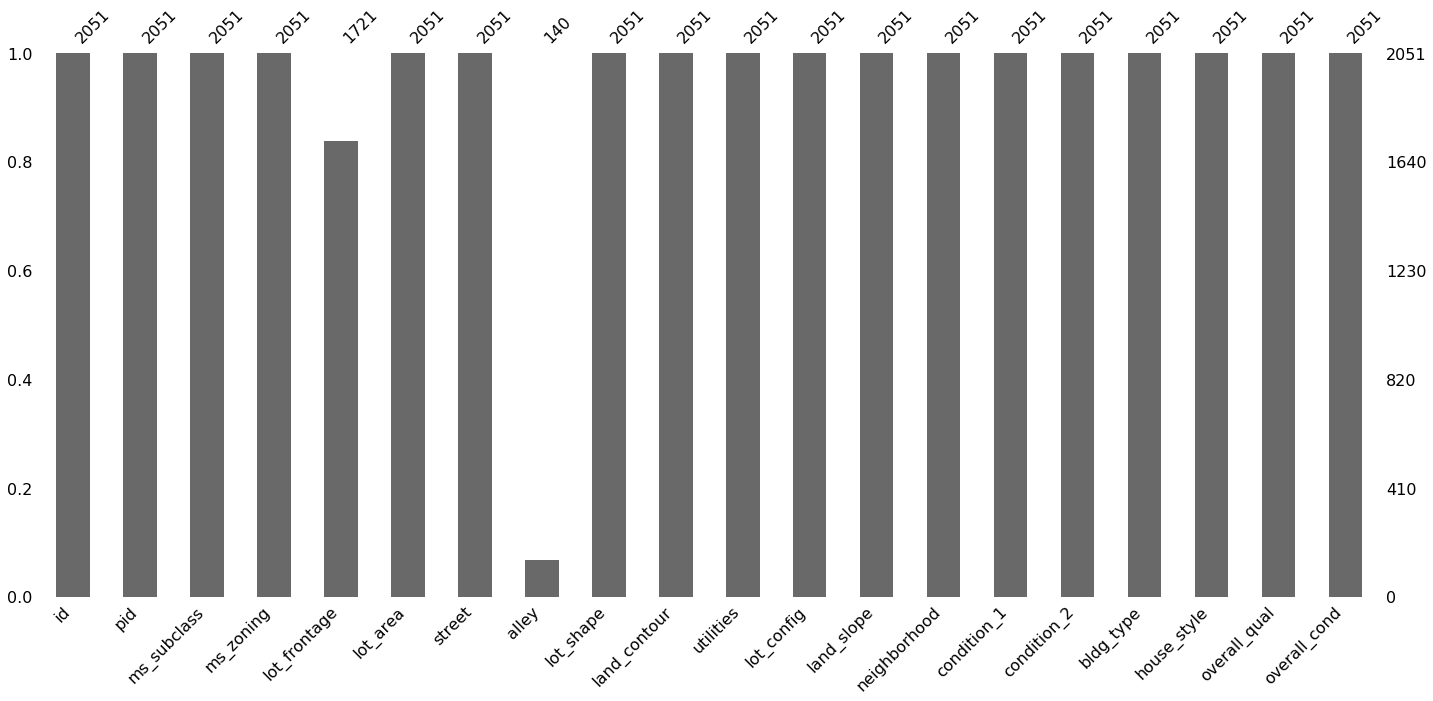

In [23]:
msno.bar(train.iloc[:, 0:20], labels=True);

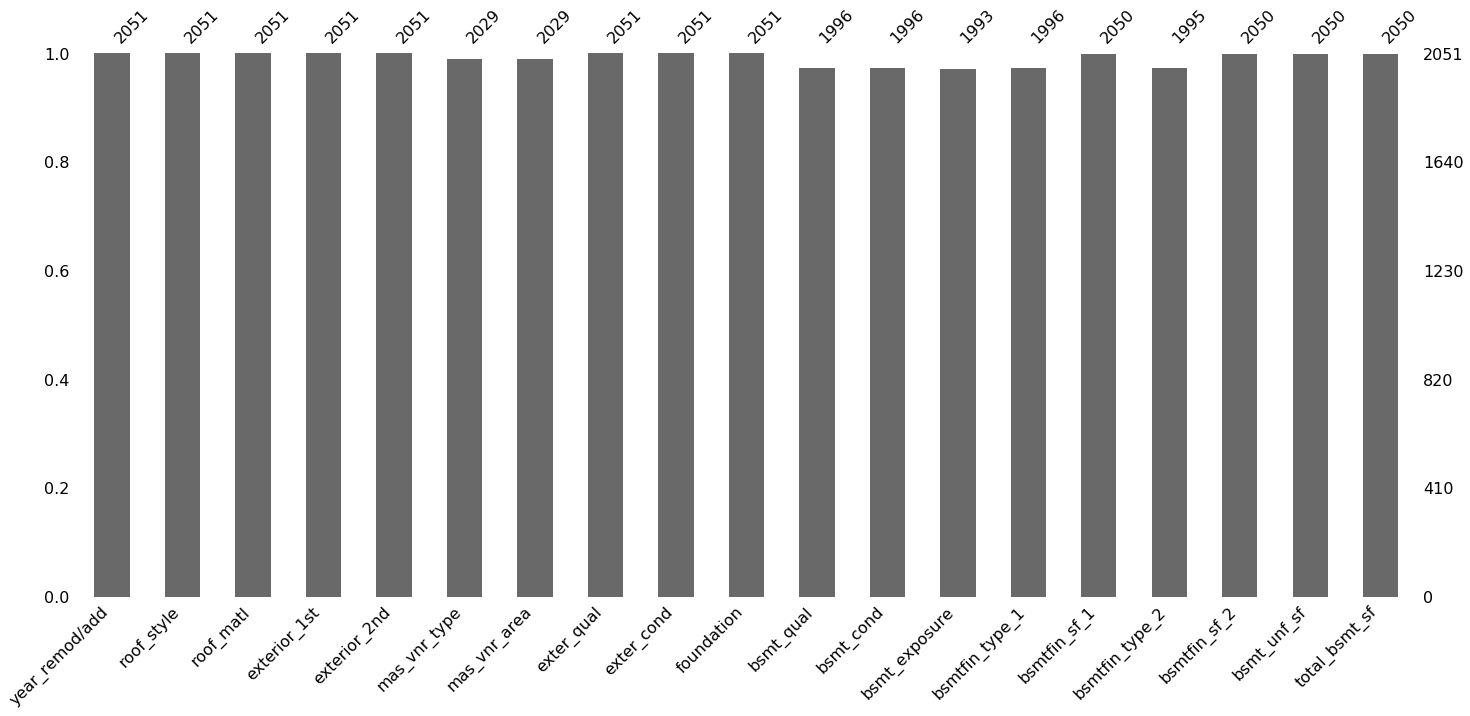

In [24]:
msno.bar(train.iloc[:, 21:40], labels=True);

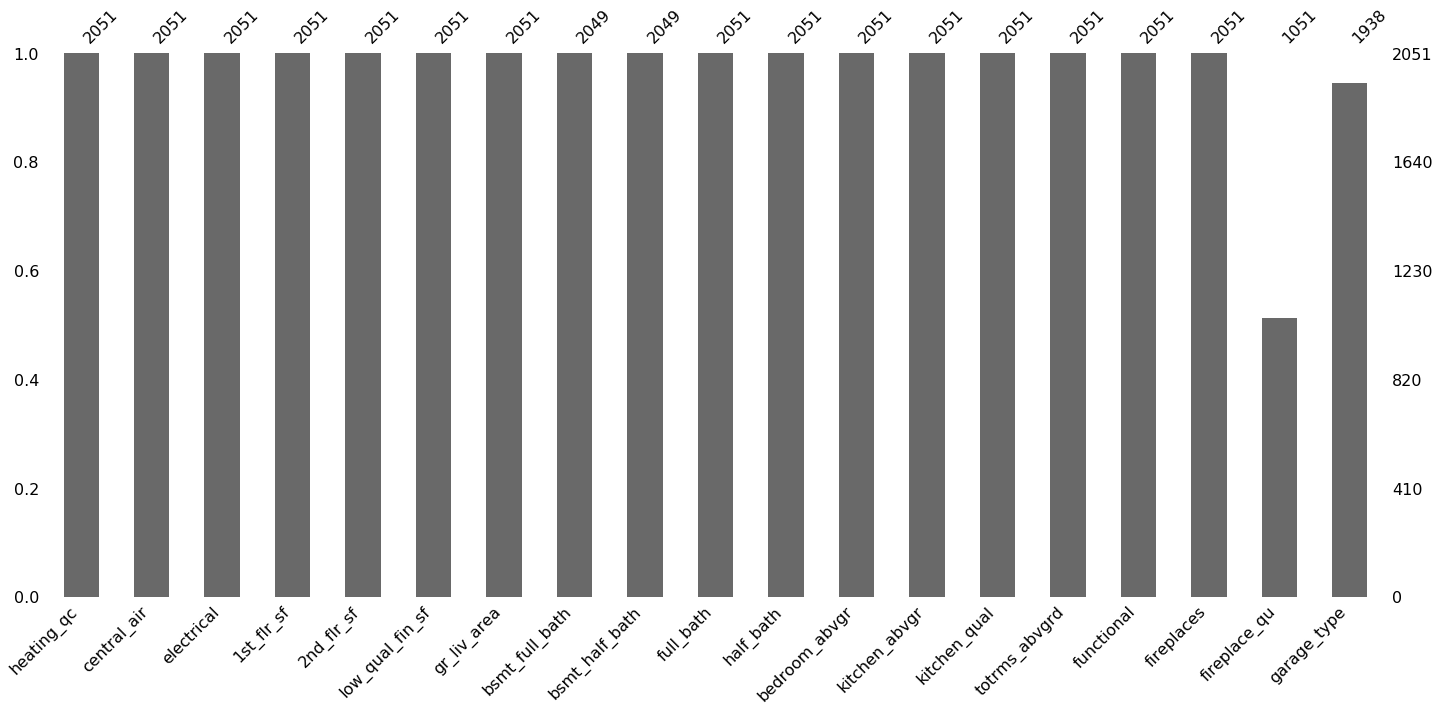

In [25]:
msno.bar(train.iloc[:, 41:60], labels=True);

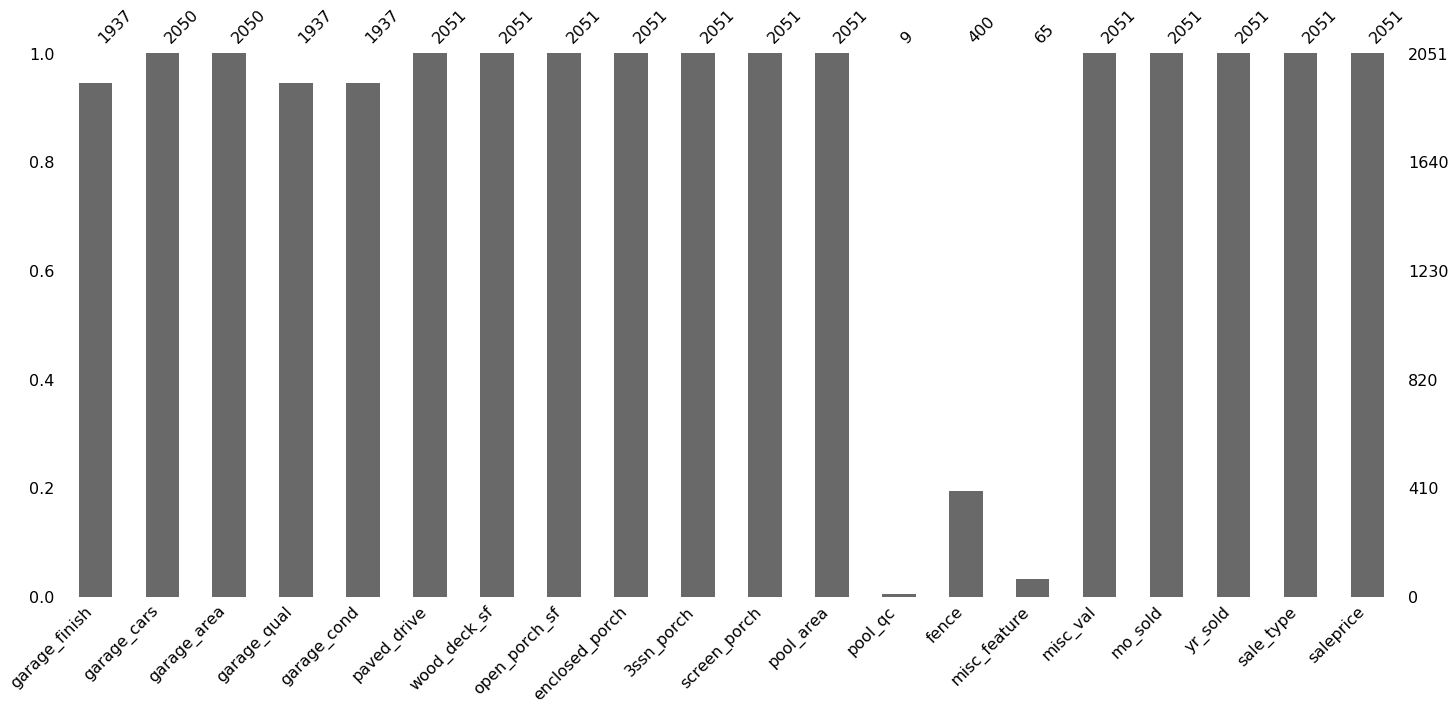

In [26]:
msno.bar(train.iloc[:, 61:], labels=True);

# Cleaning data
One option to clean our categorical data is to define a function and apply it to our data such as in the example below to convert the garage quality from its categorical labels to numeric:

In [27]:
# defining a cleaner function for 'garage_qual'
def garage_qual_cleaner(cell):
    if cell == 'Ex':
        return 5
    elif cell == 'Gd':
        return 4
    elif cell == 'TA':
        return 3
    elif cell == 'Fa':
        return 2
    elif cell == 'Po':
        return 1
    else:
        return 0
    
# applying garage qual cleaner to train data set:
train['garage_qual'].apply(garage_qual_cleaner)
# applying garage qual cleaner to test data set:
test['garage_qual'].apply(garage_qual_cleaner)

0      1
1      3
2      3
3      2
4      3
      ..
873    3
874    3
875    3
876    3
877    3
Name: garage_qual, Length: 878, dtype: int64

In [53]:
train['kitchen_qual'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1})


0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
2046   NaN
2047   NaN
2048   NaN
2049   NaN
2050   NaN
Name: kitchen_qual, Length: 2048, dtype: float64

#### But individual functions could take a long time to write and apply to various columns. Instead we can define one master function that can pythonically clean and organize the data:

In [28]:
train['mo_sold'].dtype

dtype('int64')

In [29]:
def clean_data(df):
  
    ### use to map numeric values onto all the quality columns 
    qual_dict = {'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4}
    ## just getting list of column names 
    ordinal_col_names = [col for col in df.columns if (col[-4:] in ['qual', 'cond']) and col[:3] != 'ove']
    ## creating a new feature
    df['age'] = df.apply(lambda row: row['yr_sold'] - max(row['year_built'], row['year_remod/add']), axis=1)
    ## I want to dummy this column 
    df['date_sold'] = df.apply(lambda row: str(row['mo_sold'])+ '-' + str(row['yr_sold']), axis=1)
    df.loc[:,df.dtypes!= 'object'] = df.loc[:, df.dtypes != 'object'].apply(lambda col: col.fillna(col.mean()))
    
    ## transforming columns 
    df[ordinal_col_names] = df[ordinal_col_names].applymap(lambda cell: 2 if pd.isnull(cell) else qual_dict[cell])
    
    return df

In [30]:
# applying the function to train and test data
train = clean_data(train)


In [31]:
test = clean_data(test)

## Finally check for outliers

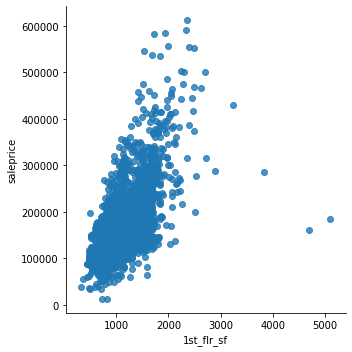

In [34]:
sns.lmplot(x='1st_flr_sf', y='saleprice', data=train, fit_reg=False);

Intuitively, we would expect to see a linear relationship between a variable such as first floor square footage and sale price (the larger the house, the higher the price). However, based on the scatterplot above, there are some outliers--large homes that have 5000 square feet on just one floor, but are relatively lower priced. We need to determine how best to handle these outliers to train our model.

In [41]:
train.loc[train['1st_flr_sf'] > 3800]

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,...,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice,age,date_sold
616,1498,908154080,20,RL,123.0,47007,Pave,NaN,IR1,Lvl,...,NaN,NaN,NaN,0,7,2008,WD,284700,12,7-2008
960,1499,908154235,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,...,Gd,NaN,NaN,0,1,2008,New,160000,0,1-2008
1885,2181,908154195,20,RL,128.0,39290,Pave,NaN,IR1,Bnk,...,NaN,NaN,Elev,17000,10,2007,New,183850,-2,10-2007


Based on the filtering above, rows  616, 960 and 1885 are our two outlier columns--I will drop these from the dataset so that they do not skew our model. Using the for loop below, we can drop the outlier observations and the by re-examining our scatter plot, our data now appears less skewed.

In [45]:
rows_to_drop = [616, 960, 1885]

for row in rows_to_drop:
    train.drop(row, inplace=True)
    

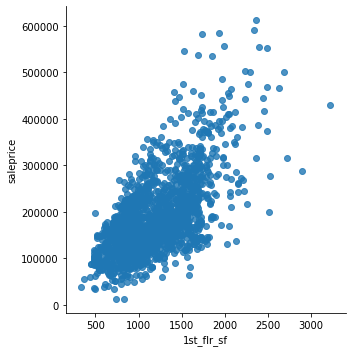

In [46]:
sns.lmplot(x='1st_flr_sf', y='saleprice', data=train, fit_reg=False);

## Export cleaned data
Now that we have cleaned the data, we can export it to new csv files that can be used to model in a new notebook.

In [49]:
train.to_csv('datasets/train_cleaned.csv', index=False)
test.to_csv('datasets/test_cleaned.csv', index=False)

In [35]:
dum_filter = (train.dtypes == 'object') & (train.isnull().mean() < .1)

dummies_train = pd.get_dummies(train.loc[:, dum_filter], dummy_na=True)

In [51]:
l = train[['fireplaces', 'fireplace_qu']]
l.corr()

,fireplaces,fireplace_qu
fireplaces,1.000000,0.859734
fireplace_qu,0.859734,1.000000


In [52]:
# noted that 'fireplaces' and 'fireplace_qu' have approx 0.86 correlation with each other...
# so create interaction term
# creating interaction term for fireplaces in 'train'
train['fireplace_interaction'] = train['fireplaces'] * train['fireplace_qu']
# creating interaction term for fireplaces in 'test'
test['fireplace_interaction'] = test['fireplaces'] * test['fireplace_qu']

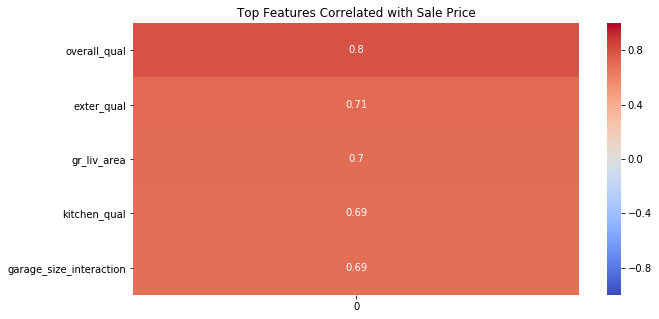

In [53]:
# adding an abs column
correlations = train.corrwith(train['SalePrice']).iloc[:-1].to_frame()
correlations['abs'] = correlations[0].abs()
#sorting 'abs' column
sorted_correlations = correlations.sort_values('abs', ascending=False)[0]


fig, ax = plt.subplots(figsize=(10,5))
ax.set_title('Top Features Correlated with Sale Price')
sns.heatmap(sorted_correlations[1:6].to_frame(), \
           cmap='coolwarm', annot=True, vmin=-1, vmax=1, ax=ax);

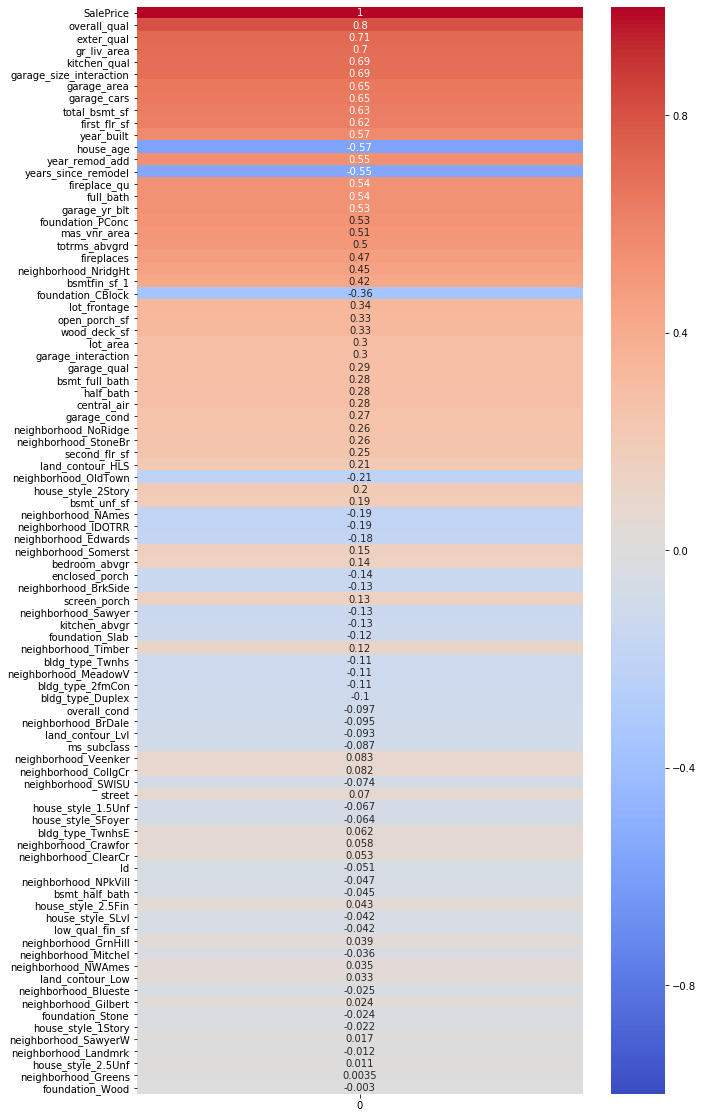

In [54]:
# adding an abs column
correlations = train.corrwith(train['SalePrice']).iloc[:-1].to_frame()
correlations['abs'] = correlations[0].abs()
#sorting 'abs' column
sorted_correlations = correlations.sort_values('abs', ascending=False)[0]

fig, ax = plt.subplots(figsize=(10,20))
sns.heatmap(sorted_correlations.to_frame(), \
           cmap='coolwarm', annot=True, vmin=-1, vmax=1, ax=ax);

In [55]:
# dropping nulls
train = train.dropna(subset=['garage_size_interaction'])
test = test.dropna(subset=['garage_size_interaction'])

In [56]:
# dropping nulls
train = train.dropna(subset=['garage_cars'])
test = test.dropna(subset=['garage_cars'])

In [57]:
# dropping nulls
train = train.dropna(subset=['total_bsmt_sf'])
test = test.dropna(subset=['total_bsmt_sf'])

In [58]:
X = train[['overall_qual', 'exter_qual', 'gr_liv_area', 'kitchen_qual',
            'garage_size_interaction', 'fireplace_interaction',
           'house_age', 'full_bath',
           'first_flr_sf', 'total_bsmt_sf', 'years_since_remodel']] 
# 'land_contour_HLS' 'neighborhood_NoRidge'  'foundation_PConc' 'totrms_abvgrd' 'central_air',
y = train['SalePrice']

In [59]:
features = ['overall_qual', 'exter_qual', 'gr_liv_area', 'kitchen_qual',
            'garage_size_interaction', 'fireplace_interaction',
            'house_age', 'full_bath',
            'first_flr_sf','total_bsmt_sf', 'years_since_remodel'] 
# 'land_contour_HLS' 'neighborhood_NoRidge', 'foundation_PConc' 'totrms_abvgrd' 'central_air',

In [60]:
# performing train_test_split
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, random_state = 42)

## Performing Linear Regression

In [61]:
lr = LinearRegression()

In [62]:
cross_val_score(lr, X_train, y_train, cv=5).mean()

0.7938445430480913

In [63]:
cross_val_score(lr, X_holdout, y_holdout, cv=5).mean()

0.849084223260488

In [64]:
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [65]:
lr.score(X_train, y_train)

0.8092200174787139

In [66]:
lr.score(X_holdout, y_holdout)

0.8521755719519105

In [67]:
predictions_lr = lr.predict(X_holdout)

In [68]:
residuals_lr = y_holdout - predictions_lr

In [69]:
np.sqrt(mean_squared_error(y_holdout, predictions_lr))

30662.023319107975

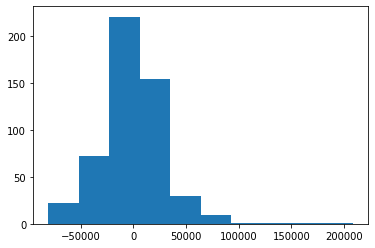

In [70]:
plt.hist(residuals_lr);

In [71]:
# evaluating linear regression coefficients
lr_coef = pd.DataFrame(lr.coef_, index=X.columns)
lr_coef

,0
overall_qual,13010.762385
exter_qual,14253.912649
gr_liv_area,39.017180
kitchen_qual,13934.646515
garage_size_interaction,17.992129
fireplace_interaction,3628.035707
house_age,-240.805470
full_bath,-3508.494985
first_flr_sf,9.913834
total_bsmt_sf,11.037716


In [72]:
import statsmodels.api as sm

In [73]:
model = sm.OLS(y_train, X_train).fit()

In [74]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              SalePrice   R-squared (uncentered):                   0.968
Model:                            OLS   Adj. R-squared (uncentered):              0.968
Method:                 Least Squares   F-statistic:                              4245.
Date:                Fri, 17 Jan 2020   Prob (F-statistic):                        0.00
Time:                        14:19:25   Log-Likelihood:                         -18262.
No. Observations:                1536   AIC:                                  3.655e+04
Df Residuals:                    1525   BIC:                                  3.661e+04
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
overall_qual              1.14e+04   1121.479     10.165      0.000    9199.763    1.36e+04
exter_qual               4624.0163   2411.783      1.917      0.055    -106.746    9354.779
gr_liv_area                41.6044      2.929     14.205      0.000      35.859      47.349
kitchen_qual             8547.5748   2110.192      4.051      0.000    4408.390    1.27e+04
garage_size_interaction    19.7403      1.687     11.700      0.000      16.431      23.050
fireplace_interaction    4239.6997    477.874      8.872      0.000    3302.339    5177.060
house_age                -391.4843     40.349     -9.702      0.000    -470.630    -312.338
full_bath               -8008.7817   2312.385     -3.463      0.001   -1.25e+04   -3472.990
first_flr_sf                6.6399      4.207      1.578      0.115      -1.612      14.892
total_bsmt_sf              12.1776      3.646      3.340      0.001       5.026      19.330
years_since_remodel      -363.6333     53.518     -6.795      0.000    -468.609    -258.658
==============================================================================
Omnibus:                      562.481   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            60347.679
Skew:                          -0.698   Prob(JB):                         0.00
Kurtosis:                      33.675   Cond. No.                     8.16e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.16e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Regression Metrics on LR Data

In [75]:
# calculating MAE using predictions_lr on the holdout dataset
metrics.mean_absolute_error(y_holdout, predictions_lr)

22124.92792132537

In [76]:
# calculating MSE using predictions_lr on the holdout dataset
metrics.mean_squared_error(y_holdout, predictions_lr)

940159674.0215212

In [77]:
# calculating RMSE using predictions_lr on the holdout dataset
np.sqrt(metrics.mean_squared_error(y_holdout, predictions_lr))

30662.023319107975

In [78]:
metrics.r2_score(y_holdout, predictions_lr)

0.8521755719519104

In [79]:
import statsmodels.api as sm
model = sm.OLS(y_holdout,X_holdout).fit()

## Performing Regularization Using Ridge

In [80]:
# Instantiate our LinearRegression Model
from sklearn.linear_model import Ridge, Lasso, RidgeCV, LassoCV , LinearRegression
ridge = RidgeCV()

In [81]:
sc = StandardScaler()
X_train_sc = pd.DataFrame(sc.fit_transform(X_train), columns=X.columns)
X_holdout_sc = pd.DataFrame(sc.fit_transform(X_holdout), columns=X.columns)

In [82]:
y_train_transformed = np.log1p(y_train)
y_holdout_transformed = np.log1p(y_holdout)

In [83]:
# using cross_validation_score to evaluate model
cross_val_score(ridge, X_train_sc, y_train_transformed, cv=5).mean()

0.8144371129768405

In [84]:
cross_val_score(ridge, X_holdout_sc, y_holdout_transformed, cv=5).mean()

0.8345383310034531

In [85]:
# fitting model to the training data
ridge.fit(X_train_sc, y_train_transformed)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=None, fit_intercept=True,
        gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)

In [86]:
# evaluating training scores
ridge.score(X_train_sc, y_train_transformed)

0.8291973641131354

In [87]:
# evaluating holdout scores
predictions_ridge = ridge.predict(X_holdout_sc)

In [88]:
predictions_ridge_clean = np.expm1(predictions_ridge)

In [89]:
r2_score(y_holdout, predictions_ridge_clean)

0.8938656872319087

In [90]:
residuals_ridge = y_holdout - predictions_ridge_clean

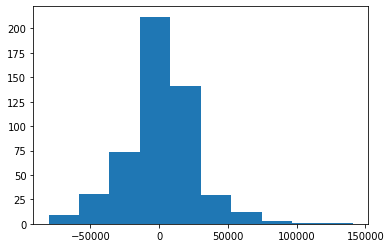

In [91]:
plt.hist(residuals_ridge);

In [92]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(y_holdout, predictions_ridge_clean))

25980.984989987563

## Employing a Grid Search to Identify whether the optimal parameters for ridge regression!

In [93]:
from sklearn.model_selection import GridSearchCV
Ridge()

params = { 
    'alpha': [-20, -10,-1,1,10,20],
    'max_iter':[1e6]

}

gs = GridSearchCV(Ridge(), param_grid=params, cv=5)

In [94]:
gs.fit(X_train_sc, y_train_transformed)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [-20, -10, -1, 1, 10, 20],
                         'max_iter': [1000000.0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [95]:
gs.best_params_

{'alpha': 20, 'max_iter': 1000000.0}

In [96]:
gs.score(X_holdout_sc, y_holdout_transformed)

0.8326014682204321

In [97]:
## call in train
train_filtered = train.loc[train['gr_liv_area'] <= 5000]


In [98]:
X = train_filtered[features]
y = train_filtered['SalePrice']

In [99]:
X_sc = pd.DataFrame(sc.fit_transform(X), columns=X.columns)

In [100]:
y_transformed = np.log1p(y)

In [101]:
gs.fit(X_sc, y_transformed)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [-20, -10, -1, 1, 10, 20],
                         'max_iter': [1000000.0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [102]:
gs.best_estimator_.score(X_sc, y_transformed)

0.8614157917188627

In [103]:
# Based on best params above, re-run ridge with these new parameers
best_ridge = gs.best_estimator_ 

In [104]:
cross_val_score(best_ridge, X_sc, y_transformed, cv=5).mean()

0.8610211041942453

In [105]:
predictions_ridge_best = best_ridge.predict(X_sc)

In [106]:
predictions_ridge_best_clean = np.expm1(predictions_ridge_best)

In [107]:
r2_score(y, predictions_ridge_best_clean)

0.897625441144383

In [108]:
residuals_ridge_best = y - predictions_ridge_best_clean

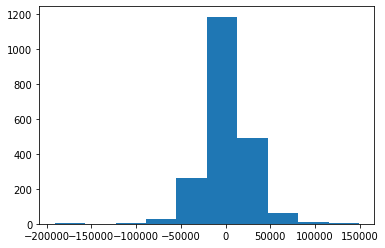

In [109]:
plt.hist(residuals_ridge_best);

In [110]:
np.sqrt(mean_squared_error(y, predictions_ridge_best_clean))

25366.45640467485

In [111]:
residuals_ridge_best.shape

(2047,)

In [112]:
## Applying model to 'Test' Dataframe

In [113]:
X_test = test[features]

In [114]:
# scale X test then exponentiate
X_test_sc = pd.DataFrame(sc.transform(X_test), columns=X.columns)

predictions_test = best_ridge.predict(X_test_sc) # output is a series of sale prices

In [115]:
## get in form that can be submitted to kaggle

test['SalePrice'] = np.expm1(predictions_test)


In [116]:
submission = test[['Id', 'SalePrice']]

In [117]:
submission.to_csv('./submission01_17_v1.csv', index=False)

In [118]:
r2_score(y_holdout, predictions_ridge_clean)

0.8938656872319087